# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [1]:
import pandas as pd 
import numpy as np 
import numpy.linalg as la
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm

from scipy.stats import t

## Read data 

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary

print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

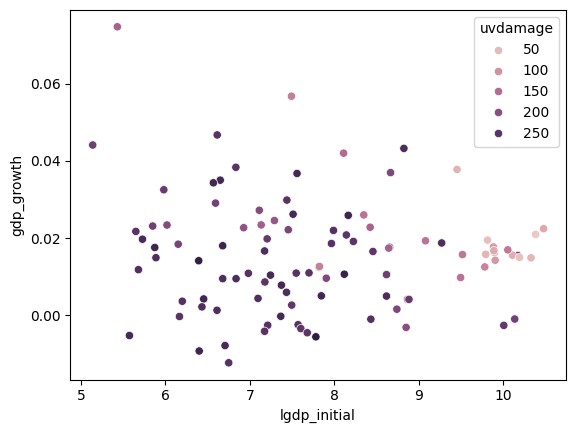

In [3]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='uvdamage');
plt.savefig("scatter.pdf")

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [4]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

print(vv_all)


{'institutions': ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'], 'geography': ['tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini', 'elevavg', 'elevstd', 'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'landlock', 'africa', 'asia', 'oceania', 'americas'], 'geneticdiversity': ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa'], 'historical': ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'], 'religion': ['pprotest', 'pcatholic', 'pmuslim'], 'danger': ['yellow', 'malfal', 'uvdamage'], 'resources': ['oilres', 'goldm', 'iron', 'silv', 'zinc'], 'educ': ['ls_bl', 'lh_bl'], 'all': ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg', 'tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini', 'elevavg', 'elevstd', 'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'landlock', 'africa', 'asia', 'oceania', 'americas', 'pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa', 'pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst', 'pprotest', 'pcathol

In [5]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))


# Simple OLS

In [6]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [7]:
vs = vv_all['geography'] + vv_all['resources'] + vv_all['danger'] 

xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs
 
# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%



#oo = np.ones((I.sum(),1))

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

print(X.shape)
xs_np = np.array(xs)

(88, 32)


## ESTIMATING $\beta$


In [8]:
def standardize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=1)
    X_tilde = (X - mu)/sigma
    return X_tilde

X_tilde=standardize(X)

In [9]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.01, 2, num = 100) # We rescale here to get a closer look. Becomes relevant at the bottom of the file

In [10]:
def plot_lasso_path(penalty_grid, coefs, legends, vlines: dict = None):
    """
    Plots the coefficients as a function of the penalty parameter for Lasso regression.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    coefs (array-like): The estimated coefficients for each penalty value.
    legends (list): The labels for each coefficient estimate.
    vlines (dict, optional): A dictionary of vertical lines to add to the plot. The keys are the names of the lines and the values are the penalty values where the lines should be drawn.
    
    """

    # Initiate figure 
    fig, ax = plt.subplots()

    # Plot coefficients as a function of the penalty parameter
    ax.plot(penalty_grid, coefs)

    # Set log scale for the x-axis
    ax.set_xscale('log')

    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
    plt.title('Lasso Path')

    # Add legends
    lgd=ax.legend(legends,loc=(1.04,0))
    
    # Add vertical lines
    if vlines is not None:
        for name, penalty in vlines.items():
            ax.axvline(x=penalty, linestyle='--', color='grey')
            plt.text(penalty,-0.2,name,rotation=90)

    # Display plot
    plt.show()
    plt.close()


In [11]:
def plot_MSE_path(penalty_grid, MSE):
    """
    Plots the mean squared error (MSE) as a function of the penalty parameter.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    MSE (array-like): The corresponding MSE values.

    """
    # Initiate figure 
    fig, ax = plt.subplots()

    # Plot MSE as a function of the penalty parameter
    ax.plot(penalty_grid, MSE)

    # Set log scale for the x-axis
    ax.set_xscale('log')
    
    # Plot minimum MSE
    min_MSE_idx = np.argmin(MSE)
    min_MSE_penalty = penalty_grid[min_MSE_idx]
    ax.axvline(x=min_MSE_penalty, linestyle='--', color='grey')
    #plt.text(min_MSE_penalty,10,"Minimum MSE",rotation=90)

    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel('Mean squared error')
    plt.title('Mean squared error')

    #fig.set_size_inches(12, 8)

    # Display plot
    plt.show()
    plt.close()


In [12]:
def BCCH_calc(X_tilde, y):
    # BCCH pilot penalty
    n,p = X_tilde.shape
    c = 1.1
    alpha = 0.05
    yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
    #print('Penalty_pilot: ', round(penalty_pilot, 2))

    # Pilot estimates
    #Create predicted value using Lasso 
    pred = Lasso(alpha=penalty_pilot).fit(X_tilde,y).predict(X_tilde)

    """
    # Alternative: Manually
    coeff_pilot = Lasso(alpha=penalty_pilot).fit(X_tilde,y).coef_
    coef_intercept = Lasso(alpha=penalty_pilot).fit(X_tilde,y).intercept_
    pred = (coef_intercept + X_tilde@coeff_pilot)
    """

    # Updated penalty
    eps = y - pred 
    epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
    my_penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
    #print('Penalty BCCH: ', round(my_penalty_BCCH, 2))

    return my_penalty_BCCH


In [13]:
d = dat.loc[I, xs[:1]].values
Z = dat.loc[I, xs[1:]].values

# Check that we get the shapes right
print("d.shape: " + str(d.shape))
print("Z.shape: " + str(Z.shape))
print("X.shape: " + str(X.shape))

X_stan = standardize(X)
Z_stan = standardize(Z)
d_stan = standardize(d)

d.shape: (88, 1)
Z.shape: (88, 31)
X.shape: (88, 32)


## 1: OLS

In [14]:
def OLS_estimate(my_X, my_y):
    # Add a constant to X
    N,p =X_tilde.shape
    xx = np.column_stack((np.ones(N), my_X))

    # Reshape y
    yy = np.array(my_y).reshape(-1,1)

    # Calculate OLS estimate
    coefs_OLS = la.inv(xx.T@xx)@xx.T@yy
    alpha_OLS = coefs_OLS[1][0]

    # Calculate residuals
    res_OLS = yy-xx@coefs_OLS

    # Estimate variance
    SSR = np.sum(res_OLS ** 2)
    sigma2_OLS = SSR/(N-xx.shape[1])
    var = sigma2_OLS*la.inv(xx.T@xx)

    # Calculate standard errors
    se = np.sqrt(np.diagonal(var)).reshape(-1, 1)

    # Get standard error of alpha
    se_OLS = se[1][0]

    # Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
    q = norm.ppf(1-0.025)

    # Calculate confidence interval
    CI_low_OLS  = alpha_OLS-q*se_OLS
    CI_high_OLS = alpha_OLS+q*se_OLS

    # Display confidence interval
    CI_OLS =  (((alpha_OLS-q*se_OLS).round(2),(alpha_OLS+q*se_OLS).round(2)))

    return [alpha_OLS, se_OLS, CI_low_OLS, CI_high_OLS]

OLS_results = OLS_estimate(X_tilde, y)
OLS_results_nocovariate = OLS_estimate(X_tilde[:,0], y)

## 2: PSL

In [15]:
# Make a function that calculates BRT
def BRT(X_tilde,y):
    N,p =X_tilde.shape
    sigma = np.std(y, ddof=1)
    c = 1.1
    alpha = 0.05

    penalty_BRT= (sigma * c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p)) # on normalised data since sum of squares is =1, NB div by 2
    #print("Penalty BRT is ", str(penalty_BRT))
    return penalty_BRT

def PSL_estimate(PSL_penalty, type_penalty=''):
    N,p = X_tilde.shape
    
    # Run Lasso 
    if type_penalty == 'cv':
        fit_yx = LassoCV(cv=5, alphas=penalty_grid).fit(X_stan, y)
    else:
        fit_yx=Lasso(alpha=PSL_penalty, max_iter=1000).fit(X_stan, y)
    
    coefs=fit_yx.coef_

    # Save variables where coefficients are not zero. Removes constant from estimation procedure.
    Z_J = Z[:,coefs[1:]!=0]

    # Step 2: Regress Y using D and Z_J
    # Add a constant to X
    xx=np.column_stack((np.ones(N), d, Z_J))
    yy=np.array(y).reshape(-1,1)

    # Calculate OLS estimate
    coefs_PSL = la.inv(xx.T@xx)@xx.T@yy
    alpha_PSL = coefs_PSL[1][0]

    # Calculate residuals
    res_PSL=yy-xx@coefs_PSL

    # Estimate variance
    SSR = np.sum(res_PSL ** 2)
    sigma2_PSL = SSR/(N-xx.shape[1])
    var = sigma2_PSL*la.inv(xx.T@xx)

    # Calculate standard errors
    se = np.sqrt(np.diagonal(var)).reshape(-1, 1)
    se_PSL=se[1][0]

    # Calculate the z statistic that corresponds to the 95% confidence interval of a two-sided test
    q = norm.ppf(1-0.025)

    # Calculate confidence interval
    CI_low_PSL  = alpha_PSL-q*se_PSL
    CI_high_PSL = alpha_PSL+q*se_PSL

    # Display confidence interval
    CI_PSL =  (((alpha_PSL-q*se_PSL).round(2),(alpha_PSL+q*se_PSL).round(2)))

    return coefs, [alpha_PSL, se_PSL, CI_low_PSL, CI_high_PSL]

# BRT ESTIMATE
coefs_BRT_PSL, PSL_BRT_results = PSL_estimate(BRT(X_tilde, y))

# BCCH
coefs_BCCH_PSL, PSL_BCCH_results = PSL_estimate(BCCH_calc(X_tilde, y))

# CV
coefs_CV_PSL, PSL_CV_results = PSL_estimate(0, type_penalty='cv')


c:\Users\hjalt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### PDL

In [16]:
def help_estimate(my_X, my_Y, my_type):
    if my_type == 'bcch':
        penalty = BCCH_calc(my_X, my_Y)
    else:
        penalty = BRT(my_X, my_Y)
    
    if my_type == 'cv':
        my_fit = LassoCV(cv=5, alphas=penalty_grid).fit(my_X, my_Y)
        penalty = my_fit.alpha_
    else:
        my_fit = Lasso(alpha=penalty, max_iter=10000).fit(my_X, my_Y) 

    return penalty, my_fit

def PDL_estimate(type_penalty=''):
    N,p=X_tilde.shape

    # Step 1: Lasso Y using D and Z 
    lambda_1, fit_yx = help_estimate(X_tilde, y, type_penalty)
    coefs_1=fit_yx.coef_

    resyx=y-fit_yx.predict(X_stan)

    # Calculate Y - Z@gamma
    resyxz = resyx + d_stan*coefs_1[0]

    # Step 2: Lasso D using Z
    lambda_2, fit_dz = help_estimate(Z_stan, d, type_penalty)
    
    coefs_2=fit_dz.coef_

    # Calculate residuals
    resdz=d-fit_dz.predict(Z_stan)

    # Calculate alpha
    num = np.sum(resdz*resyxz)
    denom = np.sum(resdz*d)
    alpha_PDL = num/denom

    # Calculate variance    
    num = np.sum(resyx**2 * resdz**2) / N
    denom = (np.sum(resdz**2) / N)**2
    sigma2_PDL = num/denom

    # Calculate standard error
    se_PDL=np.sqrt(sigma2_PDL) /np.sqrt(N)

    # Calculate confidence interval
    q = norm.ppf(1-0.025)
    CI_low_PDL  = alpha_PDL - q*se_PDL
    CI_high_PDL = alpha_PDL + q*se_PDL

    return [lambda_1, lambda_2], [coefs_1, coefs_2], [alpha_PDL, se_PDL, CI_low_PDL, CI_high_PDL]

# BRT
penalties_BRT_paths, coefs_BRT_PDL, PDL_BRT_results = PDL_estimate('brt')

# BCCH
penalties_BCCH_paths, coefs_BCCH_PDL, PDL_BCCH_results = PDL_estimate('bcch')

# CV
penalties_CV_paths, coefs_CV_PDL, PDL_CV_results = PDL_estimate('cv')

c:\Users\hjalt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\hjalt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## PPOL

In [17]:
def PPOL_estimate(type_penalty=''):
    N,p = X_tilde.shape
    ############ Step 1: Lasso Y using Z
    
    _, fit_yz = help_estimate(Z_stan, y, type_penalty)
    _coefs_1=fit_yz.coef_

    # Calculate residuals
    resyz = y-fit_yz.predict(Z_stan)  

    ####### Step 2: Lasso D and Z
    _, fit_dz = help_estimate(Z_stan, d, type_penalty) 
    _coefs_2=fit_dz.coef_

    # Calculate residuals
    resdz=d-fit_dz.predict(Z_stan)

    # Calculate alpha
    num = np.sum(resdz*resyz)
    denom = np.sum(resdz**2)
    alpha_PPOL = num/denom

    # Calculate variance    
    num = np.sum(resyz**2 * resdz**2) / N
    denom = (np.sum(resdz**2) / N)**2
    sigma2_PPOL = num/denom

    # Calculate standard error
    se_PPOL=np.sqrt(sigma2_PPOL) /np.sqrt(N)

    # Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
    q = norm.ppf(1-0.025)

    # Calculate confidence interval
    CI_low_PPOL  = alpha_PPOL - q*se_PPOL
    CI_high_PPOL = alpha_PPOL + q*se_PPOL
    
    return [_coefs_1, _coefs_2], [alpha_PPOL, se_PPOL, CI_low_PPOL, CI_high_PPOL]



coefs_BRT_PPOL, PPOL_BRT_results = PPOL_estimate('brt')

coefs_BCCH_PPOL, PPOL_BCCH_results = PPOL_estimate('bcch')

coefs_CV_PPOL, PPOL_CV_results = PPOL_estimate('cv')


c:\Users\hjalt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\hjalt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
#### NOTE TO SELF: OLS IN STANDARD UNITS
# Create a dictionary with BRT results
results = {'OLS'   : OLS_results, 
           'PSL'   : PSL_BRT_results,
           'PDL'   : PDL_BRT_results,
           'PPOL'  : PPOL_BRT_results}

# Create a dataframe from the dictionary
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Estimate of alpha', 'Standard error', 'Low bound of CI', 'High bound of CI'])

# Format the dataframe to two digits after the comma
#df_BRT = df_results.round(2)

print("BRT")
# Display the dataframe
#df_BRT

BRT


In [19]:
# Create a dictionary with BCCH results
results = {'OLS'   : OLS_results, 
           'PSL'   : PSL_BCCH_results,
           'PDL'   : PDL_BCCH_results,
           'PPOL'  : PPOL_BCCH_results}

# Create a dataframe from the dictionary
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Estimate of alpha', 'Standard error', 'Low bound of CI', 'High bound of CI'])

# Format the dataframe to two digits after the comma
#df_BCCH = df_results.round(2)

# Display the dataframe
print("--------- BCCH")
#df_BCCH



--------- BCCH


In [20]:
# Create a dictionary with CV results
results = {'OLS'   : OLS_results, 
           'PSL'   : PSL_CV_results,
           'PDL'   : PDL_CV_results,
           'PPOL'  : PPOL_CV_results}

# Create a dataframe from the dictionary
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Estimate of alpha', 'Standard error', 'Low bound of CI', 'High bound of CI'])
# Format the dataframe to two digits after the comma
#df_CV = df_results.round(2)

# Display the dataframe
print("--------- CV")
#df_CV


--------- CV


# REPORTING SECTION

## $\beta$ estimates

In [21]:
def p_value_from_t(t_stat, df):
    return 2 * t.sf(abs(t_stat), df)

def significance_stars(p): # outputs controls sequences for LaTeX 
    if p < 0.001:
        return '\\threeS'
    elif p < 0.01:
        return '\\twoS'
    elif p < 0.05:
        return '\\oneS'
    else:
        return ''

# * p < 0.05, ** p < 0.01, *** p < 0.001 

def t_vector_to_star_vector(x, t_val): # function which maps stars onto v_values
    N, K, = x.shape
    df = N - K - 1

    p_val = [p_value_from_t(t, df) for t in t_val]
    stars = [significance_stars(p) for p in p_val]
    return stars


In [22]:
# POSTESTIMATION TABLE. Creates the custom LaTeX formatting that we want for our table.
# A lot of competiting formatting concerns going on here, but I totally recognize how this looks haha

df = df_results

# PSL
l_PSL = [PSL_CV_results, PSL_BRT_results, PSL_BCCH_results]

for i,subl in enumerate([coefs_CV_PSL, coefs_BRT_PSL, coefs_BCCH_PSL]):
    l_PSL[i].append(sum(count != 0 for count in subl))

# PDL
l_PDL = [PDL_CV_results, PDL_BRT_results, PDL_BCCH_results]

for i,subl in enumerate([coefs_CV_PDL, coefs_BRT_PDL, coefs_BCCH_PDL]):
    l_PDL[i].append(sum(count != 0 for count in subl[0]) + sum(count != 0 for count in subl[1]))

# PPOL
l_PPOL = [PPOL_CV_results, PPOL_BRT_results, PPOL_BCCH_results]

for i,subl in enumerate([coefs_CV_PPOL, coefs_BRT_PPOL, coefs_BCCH_PPOL]):
    l_PPOL[i].append(sum(count != 0 for count in subl[0]) + sum(count != 0 for count in subl[1]))

In [23]:
listtags = ['PSL', 'DPL', 'PPOL']

t_values = []

for df in [l_PSL, l_PDL, l_PPOL]:
    for j in [0,1,2]:
        t_values.append(df[j][0] / df[j][1]) 

stars = t_vector_to_star_vector(X, t_values)
stars = np.array(stars).reshape(3, 3)

In [24]:

# Final \beta regression table.
output = """"""

for i,df in enumerate([l_PSL, l_PDL, l_PPOL]):
    df = list(np.around(np.array(df),2))
    output += "\n" + listtags[i] + "\n"
    output += "&" + str(df[0][0]) + str(stars[i][0]) + "&" + "(" + str(df[0][2]) + ", " + str(df[0][3]) + ")&" + str(df[0][4]) + "\n"
    output += "&" + str(df[1][0]) + str(stars[i][1]) + "&" + "(" + str(df[1][2]) + ", " + str(df[1][3]) + ")&" + str(df[1][4]) + "\n"
    output += "&" + str(df[2][0]) + str(stars[i][2]) + "&" + "(" + str(df[2][2]) + ", " + str(df[2][3]) + ")&" + str(df[2][4]) + "\n \\\\"
    output += "&(" + str(df[0][1]) + ")&&&(" + str(df[1][1]) + ")&&&(" + str(df[2][1]) + ")\\\\"

print(output)
# Only manual adjustments necessary: Insert \multicoloumn expression and delete extra decimal on final term




PSL
&-0.9\threeS&(-1.19, -0.6)&18.0
&-0.39\twoS&(-0.62, -0.17)&2.0
&-0.12&(-0.34, 0.1)&0.0
 \\&(0.15)&&&(0.12)&&&(0.11)\\
DPL
&-0.84\threeS&(-0.86, -0.81)&36.0
&-0.12\threeS&(-0.14, -0.09)&3.0
&-0.12\threeS&(-0.15, -0.1)&1.0
 \\&(0.01)&&&(0.01)&&&(0.01)\\
PPOL
&-0.02&(-0.04, -0.0)&27.0
&-0.1\threeS&(-0.13, -0.08)&3.0
&-0.12\threeS&(-0.15, -0.1)&1.0
 \\&(0.01)&&&(0.01)&&&(0.01)\\


## OLS OUTPUT

In [25]:
# OLS OUTPUT: Covariates. 
ols_b = OLS_results[0]
ols_se = OLS_results[1]
t_ols = ols_b / ols_se 
t_star = t_vector_to_star_vector(X, [t_ols])

OLS_r = [np.round(float(i), 2) for i in OLS_results]

# insert stars here for OLS output.
OLS_output = """"""

OLS_output += "$g_i (w/ covariates)$ & " + str(OLS_r[0]) + str(t_star[0]) + " &(" + str(OLS_r[2]) + ", " + str(OLS_r[3]) + ")\\\\ \n"
OLS_output += "&(" + str(OLS_r[1]) + ")&&\\\\\n"
print(OLS_output)

$g_i (w/ covariates)$ & -1.73\threeS &(-2.25, -1.21)\\ 
&(0.27)&&\\



In [26]:
ols_b  = OLS_results_nocovariate[0]
ols_se = OLS_results_nocovariate[1]

t_ols = ols_b / ols_se 
t_star = t_vector_to_star_vector(X, [t_ols])

OLS_r = [np.round(float(i), 2) for i in OLS_results_nocovariate]



# insert stars here for OLS output.

#OLS_output = """"""

OLS_output += "$g_i (no covariates)$ & " + str(OLS_r[0]) + str(t_star[0]) + " &(" + str(OLS_r[2]) + ", " + str(OLS_r[3]) + ")\\\\ \n"
OLS_output += "&(" + str(OLS_r[1]) + ")&&\\\\"


print(OLS_output)

$g_i (w/ covariates)$ & -1.73\threeS &(-2.25, -1.21)\\ 
&(0.27)&&\\
$g_i (no covariates)$ & -0.17 &(-0.47, 0.14)\\ 
&(0.15)&&\\


# 

In [27]:
def plot_lasso_path_2(penalty_grid, coefs, legends, new_title='Lasso Path',vlines: dict = None):
    # Initiate figure 
    fig, ax = plt.subplots()

    # Plot coefficients as a function of the penalty parameter
    ax.plot(penalty_grid, coefs)

    # Set log scale for the x-axis
    ax.set_xscale('log')
    
    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
    plt.title(new_title)

    # Add legends
    lgd=ax.legend(legends,fontsize="6", loc=(1.04,0))
    
    # Add vertical lines
    if vlines is not None:
        for name, penalty in vlines.items():
            ax.axvline(x=penalty, linestyle='--', color='grey')
            plt.text(penalty,-0.2,name,rotation=90)

    # Display plot
    plt.tight_layout()
    plt.savefig(new_title + ".pdf")
    plt.show()
    plt.close()

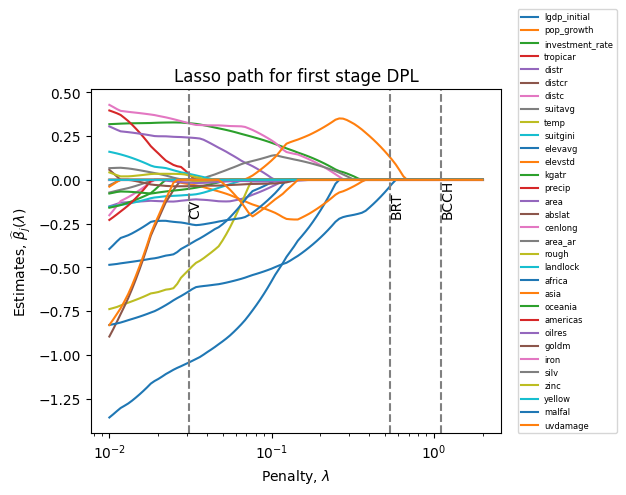

In [28]:
# LASSO PATHS: PDL

coefs_1=[]
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb).fit(X_tilde,y) 
    coefs_1.append(fit.coef_)

# Plot lasso path
plot_lasso_path_2(penalty_grid, coefs_1, xs_np, new_title="Lasso path for first stage DPL", vlines={'CV':penalties_CV_paths[0], 'BRT':penalties_BRT_paths[0], 'BCCH': penalties_BCCH_paths[0]});


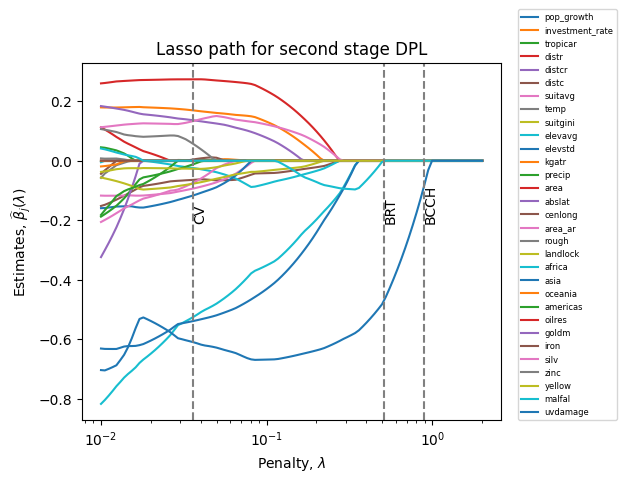

In [29]:
coefs_2=[]
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb).fit(Z_stan,d) 
    coefs_2.append(fit.coef_)

plot_lasso_path_2(penalty_grid, coefs_2, xs_np[1:], new_title="Lasso path for second stage DPL", vlines={'CV':penalties_CV_paths[1], 'BRT':penalties_BRT_paths[1], 'BCCH': penalties_BCCH_paths[1]});
